## Detecting Fake News
#### Arhum Zafar - November 2020

**This was written prior to the 2020 General Election*

### Table of Contents
1. [Introduction](#intro)
2. [Dataset](#data)
3. [What are Stopwords?](#stop)
4. [Unigrams, Bigrams, and Trigrams](#grams)
5. [Model Building](#model)
6. [Results](#results)

### Introduction <a name="intro"></a>

It's obvious that the internet has made accessing information easy to all around the world. Unfortunately, the internet has slowly turned into a hub of misinformation, or what many would call, "fake news". The problem arises when misinformation falls into the minds of wrong people, who are then convinced or persuaded to act out on the false narratives that they've heard; this can be proven by the fact of how many riots and killings have taken place in the past year. 
<br>
<br>
Fake news can even sway people's opinions and affiliations - a fact that political parties have used (and still use) to make people vote in their favour. This enhances the need to find the ability to seperate what's real from what's not. For many, doing such a thing is a difficult task -- in this notebook, I use machine learning, specifically Natural Language Processing (NLP) to classify what's fake apart from the real news.

<br>
<br>
The dataset used exists below. For obvious reasons, we'll holdout the test set until the model is ready to go.

[train](https://docs.google.com/spreadsheets/d/1mORBg2ST_PsDFAS50YAxNBYbP4pVMq6FpV3GB1fwRVY/edit?usp=sharing)
and 
[test]()

#### Import Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
import itertools
import nltk
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

#### Load Dataset

In [3]:
data = pd.read_csv("train.csv")
data.head(10)
#data.shape

,index,title,text,subject,date,class,Unnamed: 6
0,0,PRESIDENT TRUMP Explains New “America First” R...,That s what we re talking about! Another campa...,politics,"Aug 2, 2017",Fake,NaN
1,1,TERMINALLY ILL FORMER MISS WI: “Until my last ...,How is it that Sean Hannity is the only media ...,politics,"Oct 4, 2016",Fake,NaN
2,2,Cruz Humiliated By Moderator After Lie About ...,Almost immediately after learning that longtim...,News,"February 13, 2016",Fake,NaN
3,3,"Russia revels in Trump victory, looks to sanct...",MOSCOW (Reuters) - For all their mutual praise...,politicsNews,"November 9, 2016",Real,NaN
4,4,Trump's bid to open U.S. monuments to developm...,WASHINGTON (Reuters) - The Trump administratio...,politicsNews,"May 26, 2017",Real,NaN
5,5,UNREAL! HERE’S WHY ICE RELEASED BUT DIDN’T DEP...,THANK GOODNESS FOR THE CENTER FOR IMMIGRATION ...,Government News,"Apr 28, 2016",Fake,NaN
6,6,CONSEQUENCES OF LIBERAL TOLERANCE: He Had An I...,Terrified concert goers fled an Ariana Grande ...,politics,"May 25, 2017",Fake,NaN
7,7,U.S. NEWS and WORLD REPORT Publishes List Of T...,"More than 21,000 people from all regions of th...",politics,"Jul 13, 2017",Fake,NaN
8,8,Trump administration's NAFTA demands make sens...,DETROIT (Reuters) - The list of priorities U.S...,politicsNews,"July 20, 2017",Real,NaN
9,9,Turks flock to social media for gold trader sa...,ANKARA (Reuters) - Allegations of wrongdoing b...,worldnews,"December 1, 2017",Real,NaN


In [4]:
# Check for nulls
data.isnull().sum()

index             0
title             0
text              0
subject           0
date              0
class             0
Unnamed: 6    39999
dtype: int64

In [5]:
# Is out dataset imbalanced?
data["class"].value_counts()

Fake                20886
Real                19113
February 5, 2017        1
Name: class, dtype: int64

So far, I can point out two things:
<br>
1) Our dataset is somewhat balanced, with the # of "real" and "fake" classes almost being equal. <br>
2) There is a feature titled "February 5, 2017", which is different than the real and fake classes that we are looking for. I can remove this point, or shift it into the next column -- which is shown below.

In [6]:
data[data['class'] == "February 5, 2017"]

,index,title,text,subject,date,class,Unnamed: 6
504,504,Even Mitch McConnell Is Beginning To Turn On ...,Is Impeachment Next? (VIDEO),Donald Trump s Muslim ban is proving to be a l...,News,"February 5, 2017",Fake


In [7]:
# take above index and shift column values to corresponding places

data.iloc[504, 2] = data.iloc[504, 3]
data.iloc[504, 3] = data.iloc[504, 4]
data.iloc[504, 4] = data.iloc[504, 5]
data.iloc[504, 5] = data.iloc[504, 6]
data.iloc[504, 6] = np.nan

In [8]:
data.iloc[[504]]

,index,title,text,subject,date,class,Unnamed: 6
504,504,Even Mitch McConnell Is Beginning To Turn On ...,Donald Trump s Muslim ban is proving to be a l...,News,"February 5, 2017",Fake,NaN


Now that **index** and **Unnamed: 6** have become redundant, I'll go ahead and delete them.

In [9]:
data.drop(["index", "Unnamed: 6"], axis = 1, inplace = True)
data.head(3)

,title,text,subject,date,class
0,PRESIDENT TRUMP Explains New “America First” R...,That s what we re talking about! Another campa...,politics,"Aug 2, 2017",Fake
1,TERMINALLY ILL FORMER MISS WI: “Until my last ...,How is it that Sean Hannity is the only media ...,politics,"Oct 4, 2016",Fake
2,Cruz Humiliated By Moderator After Lie About ...,Almost immediately after learning that longtim...,News,"February 13, 2016",Fake


### Data <a name="data"></a>

Now that the dataframe has been cleaned up, let's take a quick look at it.

In [10]:
data.describe(include = 'all').T

,count,unique,top,freq
title,40000,35075,Factbox: Trump fills top jobs for his administ...,12
text,40000,34965,,552
subject,40000,8,politicsNews,10075
date,40000,2388,"December 20, 2017",161
class,40000,2,Fake,20887


By looking above, there are 40,000 titles and texts -- with 35,075 and 34,965 unique ones, respectively. Let's now focus on removing the non-unique ones. There are more *non-unique* entries than there are for title.

In [11]:
data.drop_duplicates(subset = ['text'], inplace=True)
data.reset_index(drop = True, inplace = True)
data.describe(include = 'all').T

,count,unique,top,freq
title,34965,34653,Factbox: Trump fills top jobs for his administ...,12
text,34965,34965,PARIS (Reuters) - France said on Wednesday it ...,1
subject,34965,8,politicsNews,10023
date,34965,2388,"December 6, 2017",149
class,34965,2,Real,18936


Now, there are 34,653 unique texts. This will suffice for analysis.
<br>
<br>
Let's look at our data.

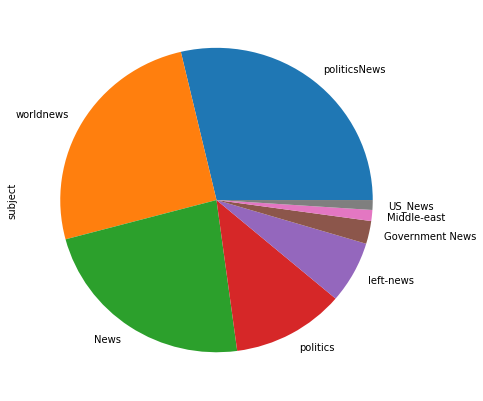

In [12]:
data['subject'].value_counts().plot.pie(figsize = (7,7))

### What are Stopwords? <a name="stop"></a>

**Stopwords** are words in the english langauge that do not add much meaning to a sentence (i.e: *hey, the, he*, etc). Thus, we can remove them without worrying about sacrificing the meaning of a sentence. <br>
<br>

When dealing with NLP, stopwords are filtered out prior to conducting analysis and building models.

In [19]:
import re
from nltk.corpus import stopwords

def stopwordsRemover(documents):
    corpus = []
    for i in range(len(data)):
        inter = re.sub('[^a-zA-Z]', ' ', documents[i])
        inter = inter.lower()
        inter = inter.split()
        
        inter = [word for word in inter if not word in stopwords.words('english')]
        inter = ' '.join(inter)
        corpus.append(inter)
    return(corpus)

# Create new titles & text index without stopwords

noSWTitle = stopwordsRemover(data["title"])
noSWText = stopwordsRemover(data["text"])

In [ ]:
# Look at some titles after removing stopwords

noSWTitle[:10]

Now that we have stopword-free titles and texts, lets update our dataframe.

In [24]:
# Insert updated features
data.insert(0, 'noSWTitle', noSWTitle, True)
data.insert(1, 'noSWText', noSWText, True)

# Drop previous features
data.drop(['title', 'text'], axis = 1, inplace = True)

In [25]:
data.head(5)

,noSWTitle,noSWText,subject,date,class
0,president trump explains new america first rai...,talking another campaign promise kept wonder d...,politics,"Aug 2, 2017",Fake
1,terminally ill former miss wi last breath use ...,sean hannity media personality able find amazi...,politics,"Oct 4, 2016",Fake
2,cruz humiliated moderator lie presidents appoi...,almost immediately learning longtime supreme c...,News,"February 13, 2016",Fake
3,russia revels trump victory looks sanctions re...,moscow reuters mutual praise russian president...,politicsNews,"November 9, 2016",Real
4,trump bid open u monuments development draws c...,washington reuters trump administration call o...,politicsNews,"May 26, 2017",Real


### Finidng Unigrams & Separating Fake from Real <a name="grams"></a>

In [29]:
fakeTitles = data.noSWTitle[data['class'] == 'Fake']
realTitles = data.noSWTitle[data['class'] == 'Real']

combinedFake = ' '.join(fakeTitles)
combinedReal = ' '.join(realTitles)

In [30]:
from nltk import word_tokenize
from nltk.util import ngrams
from collections import Counter

def ngramFunct(corpus, n):
    token = nltk.word_tokenize(corpus)
    ans = ngrams(token,n)
    return(Counter(ans))

Unigrams

In [34]:
unigramReal = ngramFunct(combinedReal, 1)
unigramFake = ngramFunct(combinedFake, 1)
ufreqReal = (nltk.FreqDist(unigramReal))
ufreqFake = (nltk.FreqDist(unigramFake))

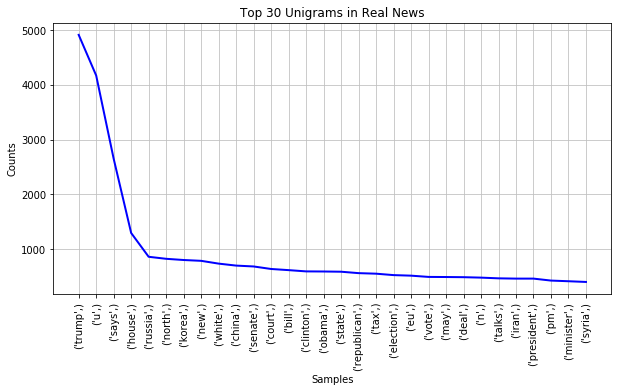

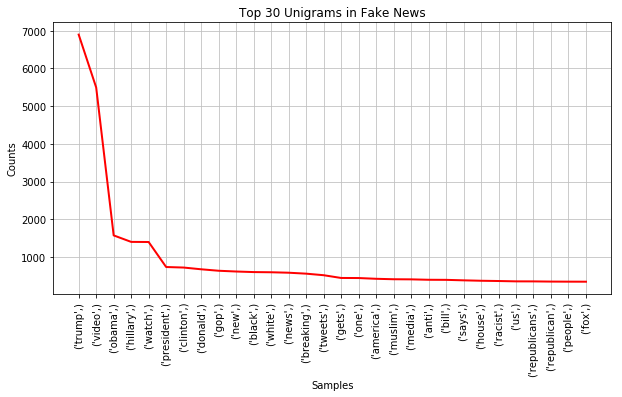

In [40]:
# Let's visualize the most common real and fake unigrams.

plt.figure(figsize=(10,5))
plt.title('Top 30 Unigrams in Real News')
ufreqReal.plot(30, cumulative=False, color = 'b');

plt.figure(figsize=(10,5))
plt.title('Top 30 Unigrams in Fake News')
ufreqFake.plot(30, cumulative=False, color = 'r');

Bigrams

In [41]:
bigramReal = ngramFunct(combinedReal, 2)
bigramFake = ngramFunct(combinedFake, 2)
bfreqReal = (nltk.FreqDist(bigramReal))
bfreqFake = (nltk.FreqDist(bigramFake))

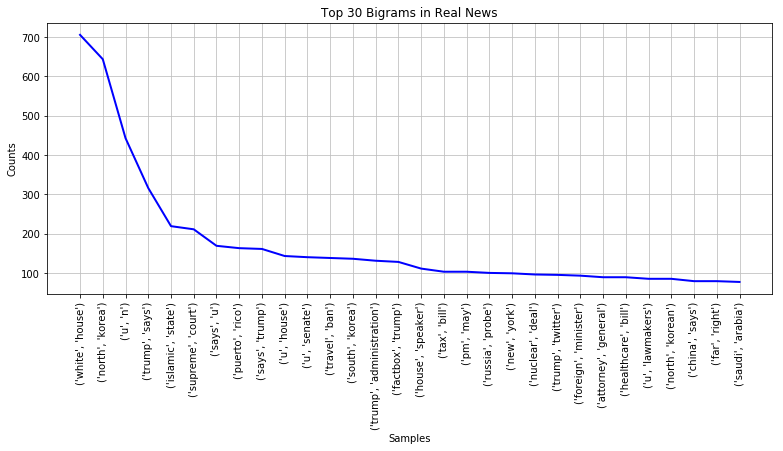

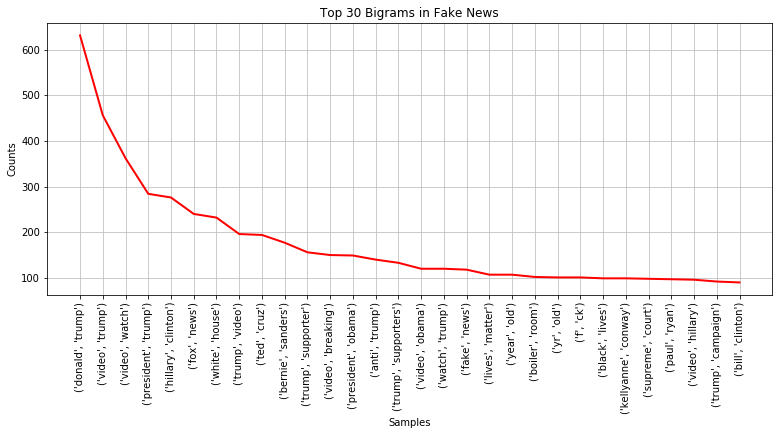

In [46]:
plt.figure(figsize=(13,5))
plt.title('Top 30 Bigrams in Real News')
bfreqReal.plot(30, cumulative=False, color = 'b');

plt.figure(figsize=(13,5))
plt.title('Top 30 Bigrams in Fake News')
bfreqFake.plot(30, cumulative=False, color = 'r');

Trigrams

In [48]:
trigramReal = ngramFunct(combinedReal, 3)
trigramFake = ngramFunct(combinedFake, 3)
tfreqReal = (nltk.FreqDist(trigramReal))
tfreqFake = (nltk.FreqDist(trigramFake))

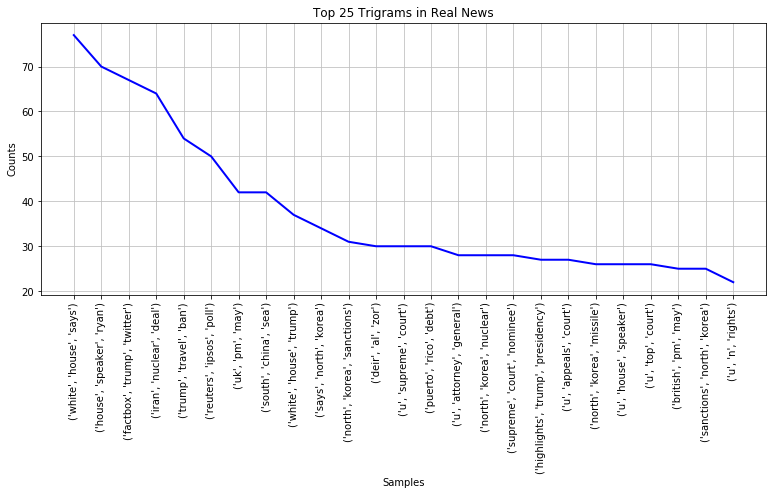

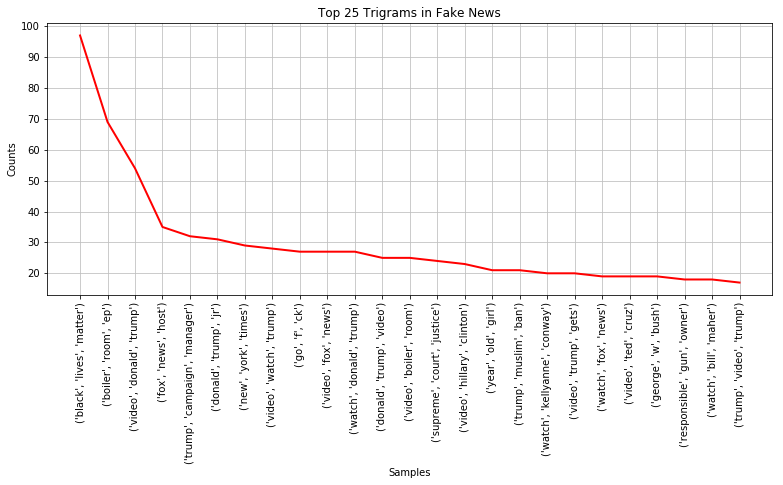

In [50]:
plt.figure(figsize=(13,5))
plt.title('Top 25 Trigrams in Real News')
tfreqReal.plot(25, cumulative=False, color = 'b');

plt.figure(figsize=(13,5))
plt.title('Top 25 Trigrams in Fake News')
tfreqFake.plot(25, cumulative=False, color = 'r');

### Model Building <a name="model"></a>

In [51]:
#Stemming words

from nltk.stem.snowball import SnowballStemmer

def stem(data):    
    stemmer = SnowballStemmer('english')
    stemmed = []
    for i in range(len(data)):
        temp = data[i]
        temp = [stemmer.stem(word) for word in temp]
        temp = ''.join(temp)
        stemmed.append(temp)
    return(stemmed)

In [54]:
# Apply the models to the Titles
titleCorpus = stem(data.noSWTitle)
titleCorpus[:10]

['president trump explains new america first raise act welfare new immigrants migrants favors english speaking immigrants protects jobs minorities us workers replaced video',
 'terminally ill former miss wi last breath use voice tell mr trump really video',
 'cruz humiliated moderator lie presidents appointing justices election year',
 'russia revels trump victory looks sanctions relief',
 'trump bid open u monuments development draws calls protection',
 'unreal ice released deport criminal illegals video',
 'consequences liberal tolerance isis flag hanging roof yet one reported video',
 'u news world report publishes list top popular nations refugees want live',
 'trump administration nafta demands make sense union pacific ceo',
 'turks flock social media gold trader sanctions case']

### TF-IDF

TF-IDF, short for term frequency-inverse document frequency, is a statistic used in NLP to demonstrate how important a word is to a document in a corpus.

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(max_features=5000, ngram_range=(1, 3))
X = tf.fit_transform(titleCorpus).toarray()
y = data['class']

In [57]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3)

#### Multinomial Naive Bayes

Accuracy : 0.952


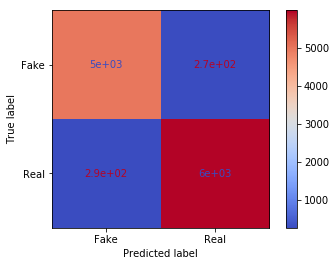

In [67]:
from sklearn.naive_bayes import MultinomialNB
classifierMNB = MultinomialNB()
classifierMNB.fit(X_train, y_train) 
pred = classifierMNB.predict(X_val)
score = metrics.accuracy_score(y_val, pred)
print('Accuracy : %0.3f' %score)

cm = plot_confusion_matrix(classifierMNB, X_val, y_val, cmap = 'coolwarm',values_format = '.5f')

#### Passive Aggressive Classifier

Accuracy : 0.991


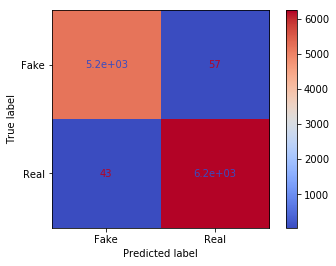

In [66]:
from sklearn.linear_model import PassiveAggressiveClassifier
classifierPAC = PassiveAggressiveClassifier(n_iter_no_change=50)
classifierPAC.fit(X_train, y_train)
pred = classifierPAC.predict(X_val)
score = metrics.accuracy_score(y_val, pred)
print('Accuracy : %0.3f' %score)
cm = plot_confusion_matrix(classifierPAC, X_val, y_val, cmap = 'coolwarm')

Let's now apply models to the text.

In [62]:
textCorpus = stem(data.noSWText)
textCorpus[:10]

['talking another campaign promise kept wonder democrats media allies fear president trump last time politician actually followed promise made american voters helped get elected president trump joined two republican senators wednesday champion legislation overhauling legal immigration america calling merit based system would significantly cut admissions next decade speaking white house president called significant reform immigration system half century candidate campaigned creating merit based immigration system protects u workers taxpayers today trump said joined georgia sen david perdue arkansas sen tom cotton republicans first introduced reforming american immigration strong economy raise act february said legislation aims reduce number green cards issued half million year trump perdue cotton argued tuesday low skilled unskilled immigration united states depressed wages according fact sheet released reporters new system would favor immigrants educated speak english high paying job o

TF-IDF

In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(max_features=5000, ngram_range=(1, 3))
X = tf.fit_transform(textCorpus).toarray()
y = data['class']

In [64]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.33)

Multinomial Naive Bayes

Accuracy : 0.952


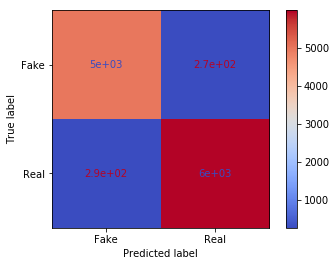

In [65]:
from sklearn.naive_bayes import MultinomialNB
classifierMNB = MultinomialNB()
classifierMNB.fit(X_train, y_train) 
pred = classifierMNB.predict(X_val)
score = metrics.accuracy_score(y_val, pred)
print('Accuracy : %0.3f' %score)

cm = plot_confusion_matrix(classifierMNB, X_val, y_val, cmap = 'coolwarm')

Passive Aggressive Classifier

Accuracy : 0.993


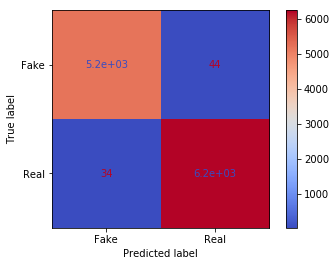

In [68]:
from sklearn.linear_model import PassiveAggressiveClassifier
classifierPAC = PassiveAggressiveClassifier(n_iter_no_change=50)
classifierPAC.fit(X_train, y_train)
pred = classifierPAC.predict(X_val)
score = metrics.accuracy_score(y_val, pred)
print('Accuracy : %0.3f'%score)
cm = plot_confusion_matrix(classifierPAC, X_val, y_val, cmap = 'coolwarm')

In [70]:
# Let's now combine both text and title, and apply the model.
data['Title and Text'] = data[['noSWTitle', 'noSWText']].apply(' '.join, axis=1)
data.head()

,noSWTitle,noSWText,subject,date,class,Title and Text
0,president trump explains new america first rai...,talking another campaign promise kept wonder d...,politics,"Aug 2, 2017",Fake,president trump explains new america first rai...
1,terminally ill former miss wi last breath use ...,sean hannity media personality able find amazi...,politics,"Oct 4, 2016",Fake,terminally ill former miss wi last breath use ...
2,cruz humiliated moderator lie presidents appoi...,almost immediately learning longtime supreme c...,News,"February 13, 2016",Fake,cruz humiliated moderator lie presidents appoi...
3,russia revels trump victory looks sanctions re...,moscow reuters mutual praise russian president...,politicsNews,"November 9, 2016",Real,russia revels trump victory looks sanctions re...
4,trump bid open u monuments development draws c...,washington reuters trump administration call o...,politicsNews,"May 26, 2017",Real,trump bid open u monuments development draws c...


In [71]:
titleTextCorpus = stem(data['Title and Text'])
titleTextCorpus[:5]

['president trump explains new america first raise act welfare new immigrants migrants favors english speaking immigrants protects jobs minorities us workers replaced video talking another campaign promise kept wonder democrats media allies fear president trump last time politician actually followed promise made american voters helped get elected president trump joined two republican senators wednesday champion legislation overhauling legal immigration america calling merit based system would significantly cut admissions next decade speaking white house president called significant reform immigration system half century candidate campaigned creating merit based immigration system protects u workers taxpayers today trump said joined georgia sen david perdue arkansas sen tom cotton republicans first introduced reforming american immigration strong economy raise act february said legislation aims reduce number green cards issued half million year trump perdue cotton argued tuesday low ski

In [76]:
#TD-IDF on both Text & Title

from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(max_features=5000, ngram_range=(1, 3))
X = tf.fit_transform(titleTextCorpus).toarray()
y = data['class']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3)

Accuracy : 0.955


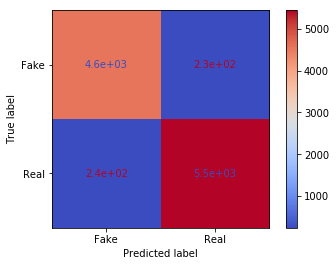

In [77]:
#Multinomial Naive Bayes

from sklearn.naive_bayes import MultinomialNB
classifierMNB = MultinomialNB()
classifierMNB.fit(X_train, y_train) 
pred = classifierMNB.predict(X_val)
score = metrics.accuracy_score(y_val, pred)
print('Accuracy : %0.3f' %score)

cm = plot_confusion_matrix(classifierMNB, X_val, y_val, cmap = 'coolwarm')

Accuracy : 0.994


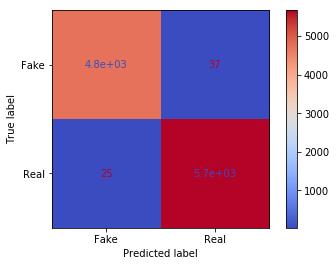

In [78]:
# Passive Aggressive Classifier

from sklearn.linear_model import PassiveAggressiveClassifier
classifierPAC = PassiveAggressiveClassifier(n_iter_no_change=50)
classifierPAC.fit(X_train, y_train)
pred = classifierPAC.predict(X_val)
score = metrics.accuracy_score(y_val, pred)
print('Accuracy : %0.3f'%score)
cm = plot_confusion_matrix(classifierPAC, X_val, y_val, cmap = 'coolwarm')

#### Results <a name="results"></a>

Now that both text and title have both been applied to the model, we can now analyze the results.
<br>
<br>
The classification accuracy is the highest when title and text are both applied together: **99.4%**.<br> The Passive Aggressive Classifier yields the best model performance, compared to Naive Bayes.